In [1]:
using Raytracing
using PyPlot
using FFTW
using BenchmarkTools

smoothe(A, x, y, σ) = real.(ifftshift(ifft(fft(A) .* fft(@. exp(-(x^2+y'^2)/σ^2)))))
;

In [2]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 10
minval = 0.5
maxval = 1.0
dpi=200
cmap = get_cmap("PuOr")
violett = PyPlot.matplotlib.colors.LinearSegmentedColormap.from_list(
             "trunc("*cmap.name*", "*string(minval)*", "*string(maxval)*")",
             cmap(range(minval, maxval, length=cmap.N)))
cmap = get_cmap("seismic")
red = PyPlot.matplotlib.colors.LinearSegmentedColormap.from_list(
             "trunc("*cmap.name*", "*string(minval)*", "*string(maxval)*")",
             cmap(range(minval, maxval, length=cmap.N)))
;

In [3]:
U = 30e3

L = 50e-6
z = 0.5
w = 15e-6

Δx = 50e-9

x = Vector{Float64}(range(-L/2, L/2-Δx, step=Δx))
y = copy(x)

extent_e = [x[1], x[end], y[1], y[end]] .* 1e6
;

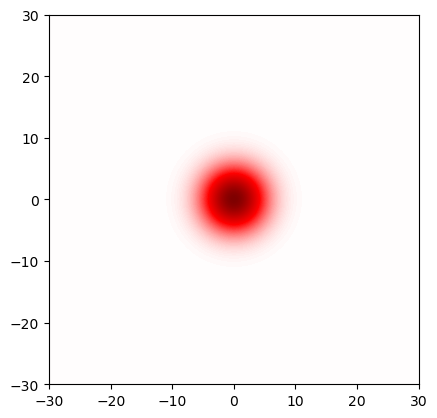

In [4]:
λ_l = 1035e-9
Δimg = 0.01e-6

wgauss = 5e-6

ximg = Vector{Float64}(range(-30e-6, 30e-6, step=Δimg))
yimg = ximg

I = @. exp(-(ximg^2+yimg'^2)/wgauss^2)
extent_l = [ximg[1], ximg[end], yimg[1], yimg[end]] .* 1e6
pygui(false)
imshow(I, extent=extent_l, cmap=red)
;

In [5]:
c = 299792458           # the speed of light
ħ = 1.054571817e-34     # the reduced planck constant
m_e = 9.1093837015e-31  # the electron mass
q = 1.602176634e-19     # electron charge
ε_0 = 8.8541878128e-12  # vacuum permitivity

v = c * sqrt(1 - 1 / (1 + q*U/m_e/c^2)^2)
α = 1 / (4 * π * ε_0) * q^2 / (ħ * c)
β = v / c
γ = 1 / sqrt(1 - β^2)
Ee = γ*m_e*c^2
;

In [6]:
# get the energy needed for the phase shift φ
φ = 1*π
norm = sum(I) * Δimg^2
E = -φ * 2 * π * (1 + β) / α / λ_l^2 * Ee * norm

ψ = smoothe([i^2 + j^2 < w^2 ? 1. : 0. for i in x, j in y], x, y, 1e-6)

eb = Electron(x, y, ψ, U, Int(20e6))
lf = LightField(I, norm, ximg, yimg, λ_l, E)

pond = PondInteraction(lf)
free = Free(z)

setup = Setup(pond, free)

propagation!(eb, setup)
;

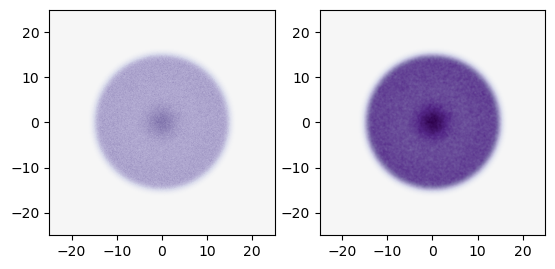

PyObject <matplotlib.image.AxesImage object at 0x7f345027cee0>

In [7]:
pygui(false)
out_int = getintensity(eb, x, y)
out_smeared = smoothe(out_int, x, y, 200e-9)
fig, (ax1, ax2) = subplots(1, 2)
ax1.imshow(out_int, cmap=violett, extent=extent_e)
ax2.imshow(out_smeared, cmap=violett, extent=extent_e)

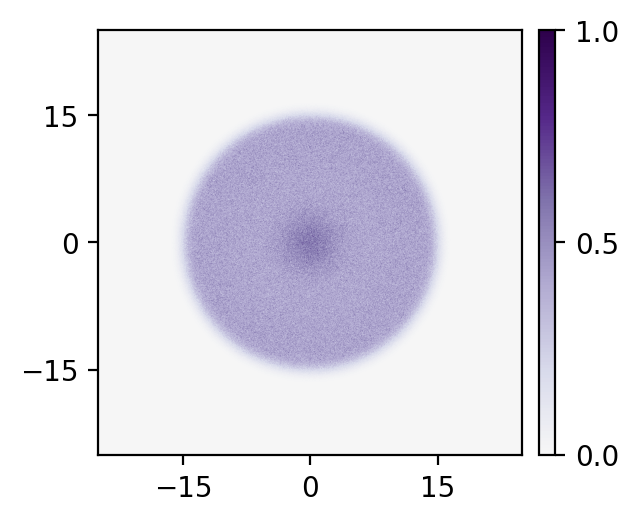

In [8]:
out = out_int ./ maximum(out_int)
out[1, 1] = 0

figsize = [7, 7] ./ 2.54

pygui(false)
fig, ax = subplots(figsize=figsize, dpi=dpi)
plt = ax.imshow(out, cmap=violett, extent=extent_e)

ax.set_xticks([-15, 0, 15])
ax.set_yticks([-15, 0, 15])

cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.03,ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[0, 0.5, 1], cax=cax)

savefig("./images/electron_distribution.svg", bbox_inches="tight", dpi=dpi)
;

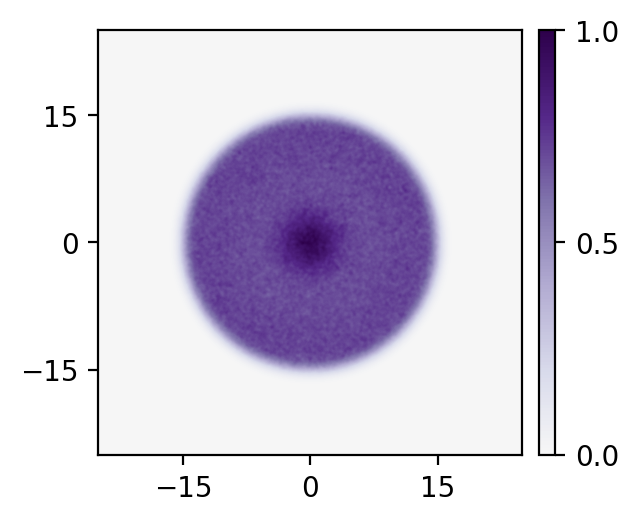

In [9]:
out = out_smeared ./ maximum(out_smeared)
out[1, 1] = 0

figsize = [7, 7] ./ 2.54

pygui(false)
fig, ax = subplots(figsize=figsize, dpi=dpi)
plt = ax.imshow(out, cmap=violett, extent=extent_e)

ax.set_xticks([-15, 0, 15])
ax.set_yticks([-15, 0, 15])

cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.03,ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[0, 0.5, 1], cax=cax)

savefig("./images/electron_distribution_smeared.svg", bbox_inches="tight", dpi=dpi)
;

In [10]:
function radialint(A::Matrix{<:Real}, x::Vector{<:Real}, y::Vector{<:Real})
    
    # define the distance matrix
    R = @. sqrt(x^2 + y'^2)
    
    # initialize the r axis and the radial distribution
    r = zeros(eltype(R), 0)
    a = zeros(eltype(A), 0)

    # create the peprmutation scheme for sorting the R and A
    perm = sortperm(vec(R))
    
    # make the matrix to vector, add permutation
    A_perm = vec(A)[perm]
    R_perm = vec(R)[perm]
    A_sum = 0
    count = 1
    rad_last = Inf
    
    @inbounds for (i, rad) in pairs(R_perm)
        
        # if we are in the first itaration, perpare the loop
        if i == 1
            A_sum = A_perm[1]
            rad_last = rad
        
        # if the current radius is the same as the one in the last iteration, raise the counter
        # and add the A value
        elseif rad_last == rad
            count += 1
            A_sum += A_perm[i]
        
        # if we have a new radius, save the old ones in appending the matrix
        # and reset the counter and the sum
        else
            append!(r, rad_last)
            append!(a, A_sum / count)
            count = 1
            A_sum = A_perm[i]
        end
        
        rad_last = rad
    end
    
    # normalize the radial distribution
    a ./= maximum(a)
    
    return r, a
end;


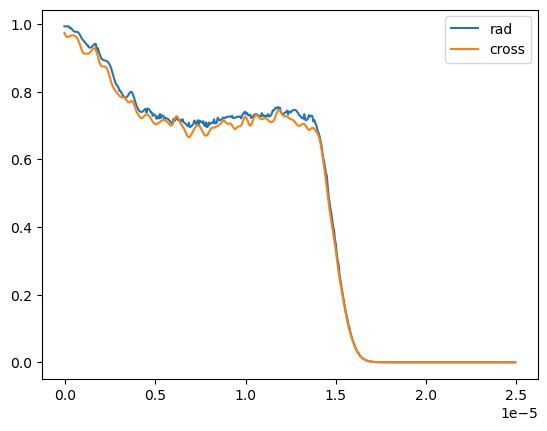

In [11]:
using Interpolations
using Array2file

r, rad = radialint(out, x, y)
xcross = x[round(Int, size(out_int, 2)/2):end]

maxind = findall(y->y==maximum(x), r)
r = r[1:maxind[1]]
rad = rad[1:maxind[1]]

interp = LinearInterpolation(r, rad, extrapolation_bc=Line())

radx = [interp(xcross[i]) for i in eachindex(xcross)]

writefile(radx, "radx.txt")
writefile(xcross, "xcross.txt")

cross = out[round(Int, size(out_int, 1)/2), round(Int, size(out_int, 2)/2):end]
plot(xcross, radx, label="rad")
plot(xcross, cross, label="cross")
legend()
;